In [1]:
%pylab inline
import os
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import keras
from keras.layers import convolutional, Dense, Activation,pooling
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
from keras import backend as K
from keras.utils import np_utils
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import cPickle as pickle
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import h5py

config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))



###################################### LOADING DATA ##############################

### Create a dictionary that contains all the dictiories within each dataset (workspace) we want to load ###
#Go to the data directory
dataDir = "/scratch/barbieri/DATA_CNN_networks/Data/"
Load_Data = {}  
for i in range(0, len(os.listdir( dataDir ))):  
    Load_Data[i] = {}  #Dictionary for a single workspace

    
### lOAD THE DATA STORING THEM IN A DICTIONARY ###
i = 0
for file in os.listdir( dataDir ):
    Load_Data[i]['File'] =  scipy.io.loadmat( dataDir+file )
    i = i+1

    
#### Define another dictionary for storing intensity curves and classes ### 
#From each dataset, the intensity curve and classes are extracted and stored in another dictionary
DATA = {}
N_of_file =len(os.listdir( dataDir ))
for i in range(0, N_of_file):
        DATA[i] = {}


#Find the minimun length among all the intensity curves
Int_curve_lengths = np.zeros(N_of_file)
for i in range(0, N_of_file):
    Int_curve_lengths [i] = (len(Load_Data[i]['File']['RAWDATA'][0,0]['files'][0,0][0]['intensity'][0][0]))
Int_curve_len = (min(Int_curve_lengths.astype(int)))


#### Fill the dictionary ###
Ncell_classified = 200 #Number of classified cells per dataset
for i in range(0, N_of_file):
    #Decision array for each dataset
    DATA[i]['decision'] = Load_Data[i]['File']['decisionlist']   
    #Size of the matrix to store intensity values
    NumofData = len(Load_Data[i]['File']['RAWDATA'][0,0]['files'][0,0][0]['intensity'])
    #Empty matrix to store all the intensity values of all the cells
    DATA[i]['intensity'] = np.zeros((Ncell_classified,  Int_curve_len ))    
    for k in range(0,Ncell_classified): #Only the first 200 were classified
        DATA[i]['intensity'][k,:] = Load_Data[i]['File']['RAWDATA'][0,0]['files'][0,0][0]['intensity'][k][0,0:900] #copy the first 900 values
    

### Classes array: contain values from all the data ###
Classes=[]
for i in range( 0, N_of_file ):
    Classes = np.append(Classes , DATA[i]['decision']).astype(int)


### Intensities matrix: contain values from all the data    
NTot_Data = N_of_file*Ncell_classified
Intensity = np.zeros((0, DATA[0]['intensity'].shape[1]))
for i in range( 0, N_of_file ):
    Intensity = np.append(Intensity, DATA[i]['intensity'][:,:], axis=0)    
    

### ELIMINATE intensity profiles with NaN values and corresponding classes ###
nan_indices = np.where(np.isnan(Intensity))
Intensity = np.delete(Intensity,nan_indices[0], axis = 0)
Classes = np.delete(Classes,nan_indices[0], axis = 0)
print('Intensity curve shape =', Intensity.shape)
print('Classes shape =', Classes.shape)
#Redefine the total number of data
total = len(Intensity)



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


('Intensity curve shape =', (990, 900))
('Classes shape =', (990,))


990
(1980, 900)


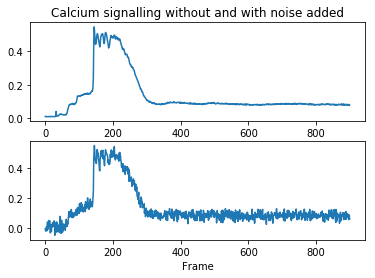

1980
(1980,)


In [2]:
# DUPLICATE Intensity profiles adding noise to the second group
print(total)
Intensity_more_curves_noise = np.zeros((2*total,  Int_curve_len ))
Intensity_more_curves_noise[0:990,:] = Intensity
Intensity_more_curves_noise[990:1980,:] = Intensity + np.random.randn(Int_curve_len)*0.02

print(Intensity_more_curves_noise.shape)



plt.figure(1)
plt.subplot(211)
plt.title('Calcium signalling without and with noise added')
plot(Intensity_more_curves_noise[1])
plt.subplot(212)
plot(Intensity_more_curves_noise[991])
plt.xlabel('Frame')
plt.savefig('13_06_2017_Curve_VS_noiseCurve.png')
plt.show()

#Redefine the total number of data
total = len(Intensity_more_curves_noise)
print(total)


#DUPLICATE CLASSES
#DUPLICATE THEM
Classes = np.append(Classes, Classes)
print(Classes.shape)

In [6]:
### Downsampling
data1 = Intensity_more_curves_noise[:,0:768]
step = 3
#256 points
data_downsampl = data1[:,::step]
print('data shape', data_downsampl.shape)

#Redefine len of the Intensity curves:
Int_profile_len = len(data_downsampl[0])


('data shape', (1980, 256))


In [7]:
#Check if there are typo errors for the classes (we only have 6 classes going from 0 to 5)
for i in range(len(Classes)):
    if Classes[i] > 5:
        print(i)

In [8]:
# define a CNN

def CNN(X, y, test_dt, test_cl, decay_val, n_iteration):
    cnn = Sequential()
    cnn.add(Convolution2D(64, 3, 1,border_mode="same",activation="relu",input_shape=(Int_profile_len,1, 1)))
    cnn.add(Convolution2D(64, 3, 1, border_mode="same", activation="relu"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Flatten())
    cnn.add(Dense(1024, activation="relu"))
    cnn.add(Dropout(0.5)) #0.5
    cnn.add(Dense(6, activation="softmax"))

    
    # define optimizer and objective, compile cnn
    compile_step = cnn.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_val),  metrics=['accuracy'])
    #default parameters coming from the paper: https://arxiv.org/abs/1412.6980v8
       
    #Store in dictionaries
    results = {}
    out = {}  
    # train
    
    filepath ="/scratch/dwaithe/13_06_2017_DropOut05_data_weights_1980Data_best_DecayValue_" + str(decay_val) + "NIteration" + str(n_iteration) + ".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Fit the model
    results = cnn.fit(X, y, nb_epoch=200, batch_size=100, callbacks=callbacks_list, validation_data=(test_dt , test_cl), verbose=0) 
    #Evaluation code which makes prediction
    out = cnn.predict(test_dt.reshape((N_test_cell, Int_profile_len,1, 1)))    
    
    return results, out


In [9]:
#Iterate the process 
decay_val = [0.01]#, 0.005, 0.001]
n_interation = 5

#Matrix to store test_cl and test_dt - DO IT
test_dt = np.zeros(((180,256,5)))  #180 data, 256 points for each data, 5 iterations
test_cl = np.zeros((5,180))

#for iteration in range(n_interation):
 #   test_dt[iteration] = {}
  #  test_cl[iteration] = {}
    

#dictionary to store the iterations
RESULTS = {} 
for iteration in range(n_interation):
    RESULTS[iteration] = {} #dictionary to store the results from the CNN
    
for iteration in range(n_interation):
    print('Iteration number =', iteration)
    
    ################### Distribute all values randomly ##################
    randseq = np.random.choice(np.arange(0,total),total,replace=False)
    #Data randomly organized
    data_downsampl = data_downsampl[randseq,:]

    Classes = Classes[randseq]    
    Classes_to_categorical = np_utils.to_categorical(Classes)

    ######################### load file - training data ####################
    train_dt = data_downsampl[0:1800,:]
    train_cl = Classes[0:1800]
    train_cl_reshape = Classes_to_categorical[0:1800]
    
    X = np.copy(train_dt)#np.random.rand(10000, 128).astype("float32")
    y = np.copy(train_cl_reshape) #np.random.randint(3, size=(10000,1))
    
    N_train_cell = len(train_dt)
    # process the data to fit in a keras CNN properly
    # input data needs to be (N, C, X, Y) - shaped where
    # N - number of samples
    # C - number of channels per sample
    # (X, Y) - sample size
    X = X.reshape((N_train_cell, Int_profile_len,1, 1))

    ######################### load file - testing data ####################
    #Define variables 
    N_test_cell = total - N_train_cell
    
    #Matrix for saving values
    test_dt[:,:, iteration]= data_downsampl[N_train_cell:total]
    test_dt_reshape = np.copy(test_dt[:,:,iteration])
    test_dt_reshape = test_dt_reshape.reshape((N_test_cell, Int_profile_len,1, 1))
    
    #Same process for the associated classes
    test_cl[iteration,:] = Classes[N_train_cell:total]
    test_cl_reshape = Classes_to_categorical[N_train_cell:total]
    
    
    #RUN THE CNN network
    for i in range(len(decay_val)):
        #print('decay value = ', decay_val[i])
        RESULTS[iteration][i] = CNN(X, y, test_dt_reshape, test_cl_reshape, decay_val[i], iteration)
        
        #ERROR
        #Saves data out using pickle. Will be file named data.p in the same directory as this notebook.
        #pickle.dump(RESULTS[i], open( "Results_CNN_Different_Decay"  + str(k) + ".p", "wb" ) )



('Iteration number =', 0)


ResourceExhaustedError: OOM when allocating tensor with shape[1024]
	 [[Node: dense_1_b/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1_b"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_1_b, Const_9)]]

Caused by op u'dense_1_b/Assign', defined at:
  File "/usr/lib64/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib64/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/t1-home/molimm2/dwaithe/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-9b0506f9c16b>", line 63, in <module>
    RESULTS[iteration][i] = CNN(X, y, test_dt_reshape, test_cl_reshape, decay_val[i], iteration)
  File "<ipython-input-8-d02da74591ce>", line 20, in CNN
    cnn.add(Dense(1024, activation="relu"))
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/keras/models.py", line 327, in add
    output_tensor = layer(self.outputs[0])
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/keras/engine/topology.py", line 543, in __call__
    self.build(input_shapes[0])
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/keras/layers/core.py", line 758, in build
    constraint=self.b_constraint)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/keras/engine/topology.py", line 415, in add_weight
    weight = initializer(shape, name=name)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/keras/initializations.py", line 98, in zero
    return K.zeros(shape, name=name)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 481, in zeros
    dtype, name)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 248, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 360, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/molimm2/dwaithe/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1024]
	 [[Node: dense_1_b/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_1_b"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_1_b, Const_9)]]


In [28]:
print(len(test_dt[0]))

256


In [83]:
"""fig, ax = plt.subplots()
ax.plot(RESULTS[4][0][0].history['acc'])
ax.plot(RESULTS[4][1][0].history['acc'])
ax.plot(RESULTS[4][2][0].history['acc'])

ax.set_xlabel('Epochs')
ax.set_title('Average LOSS and VAL_LOSS - 5 iterations - 200Epochs - Decay_0.001')
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
"""


"fig, ax = plt.subplots()\nax.plot(RESULTS[4][0][0].history['acc'])\nax.plot(RESULTS[4][1][0].history['acc'])\nax.plot(RESULTS[4][2][0].history['acc'])\n\nax.set_xlabel('Epochs')\nax.set_title('Average LOSS and VAL_LOSS - 5 iterations - 200Epochs - Decay_0.001')\nlegend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')\n"

In [84]:
#cnn.save('/scratch/dwaithe/Model_CNN_Calcium_signaling_DecayValue_Noise1800data.h5')


In [309]:
#Save LOSS and ACCURACY curve in txt files

#SAVE LOSS
for iteration in range(n_interation):
    for i in range(len(decay_val)):
        np.savetxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_LossValues_Diff_decay_Niter_"+ str(iteration)+ "_DecVal_" + str(decay_val[i]) + ".txt", RESULTS[iteration][i][0].history['loss'], newline='\r\n')

#SAVE ACCURACY
for iteration in range(n_interation):
    for i in range(len(decay_val)):
        np.savetxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_AccValues_Diff_decay_Niter_"+ str(iteration)+ "_DecVal_" + str(decay_val[i]) + ".txt", RESULTS[iteration][i][0].history['acc'], newline='\r\n')

#SAVE VAL_LOSS
for iteration in range(n_interation):
    for i in range(len(decay_val)):
        np.savetxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_Validation_LossValues_Diff_decay_Niter_"+ str(iteration)+ "_DecVal_" + str(decay_val[i]) + ".txt", RESULTS[iteration][i][0].history['val_loss'], newline='\r\n')

#SAVE VAL_ACC
for iteration in range(n_interation):
    for i in range(len(decay_val)):
        np.savetxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_Validation_AccValues_Diff_decay_Niter_"+ str(iteration)+ "_DecVal_" + str(decay_val[i]) + ".txt", RESULTS[iteration][i][0].history['val_acc'], newline='\r\n')


(200, 1)
(200, 1)


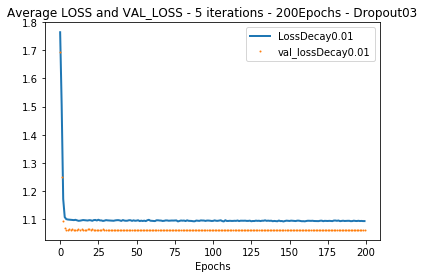

In [312]:
#Plot LOSS and val_loss - all decay
loss = {}
val_loss = {}
for k in range(len(decay_val)):
    loss[k] = np.zeros((200,n_interation))
    val_loss[k] = np.zeros((200,n_interation))

loss_mean = np.zeros((200,len(decay_val)))  #rows = n. of epochs; columns = n. of decay values
val_loss_mean = np.zeros((200,len(decay_val)))

for k in range(len(decay_val)):   #scan along all the decay values
    for iteration in range(n_interation): #scan along all the iterations
        loss[k][:,iteration] = np.loadtxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_LossValues_Diff_decay_Niter_" + str(iteration) + "_DecVal_" + str(decay_val[k]) + ".txt")
        val_loss[k][:,iteration] = np.loadtxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_Validation_LossValues_Diff_decay_Niter_" + str(iteration) + "_DecVal_" + str(decay_val[k]) + ".txt")

        #AVERAGE OF THE loss
        loss_mean[:,k] = np.mean(loss[k], axis = 1) 
        #AVERAGE OF THE VAL_Loss
        val_loss_mean[:,k] = np.mean(val_loss[k], axis = 1)  
        

print(loss_mean.shape)
print(val_loss_mean.shape)
#PLOT
fig, ax = plt.subplots()
for i in range(len(decay_val)):
    ax.plot(loss_mean[:,i],'-', linewidth=2, label = 'Loss'+'Decay'+str(decay_val[i]))
    ax.plot(val_loss_mean[:,i],'o', ms=1, label = 'val_loss'+'Decay'+str(decay_val[i]))

ax.set_xlabel('Epochs')
ax.set_title('Average LOSS and VAL_LOSS - 5 iterations - 200Epochs - Dropout05')
legend = plt.legend(loc='upper right', shadow=False, prop={'size':10})
fig.savefig('/scratch/dwaithe/13_06_2017_DropOut05_1980Data_LOSS_and_VAL_Loss_5iterations_Epoches200_decay01.png')

In [318]:
#Plot ACC and val_acc - Decay 0.005
acc = {}
val_acc = {}


for k in range(len(decay_val)):
    acc[k] = np.zeros((200,n_interation))
    val_acc[k] = np.zeros((200,n_interation))
    
acc_mean = np.zeros((200,len(decay_val)))  #rows = n. of epochs; columns = n. of decay values
val_acc_mean = np.zeros((200,len(decay_val)))

for k in range(len(decay_val)):
    for iteration in range(n_interation):
        acc[k][:,iteration] = np.loadtxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_AccValues_Diff_decay_Niter_" + str(iteration) + "_DecVal_" + str(decay_val[k]) + ".txt")
        val_acc[k][:,iteration] = np.loadtxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_Validation_AccValues_Diff_decay_Niter_" + str(iteration) + "_DecVal_" + str(decay_val[k]) + ".txt")

        for epoch in range(200):
            #AVERAGE OF THE ACC
            acc_mean[:,k] = np.mean(acc[k], axis = 1) 
            #AVERAGE OF THE VAL_ACC
            val_acc_mean[:,k] = np.mean(val_acc[k], axis = 1)  

        


[ 1.77011153  1.57267791  1.20658655  1.11232031  1.09921437  1.10413334
  1.09845883  1.09735109  1.09778341  1.09777098  1.1029274   1.0963969
  1.09656832  1.09494077  1.09437567  1.09598606  1.09761898  1.09781147
  1.09595888  1.09931593  1.09519002  1.09486818  1.09903452  1.09780129
  1.10057793  1.09798812  1.09969882  1.09368591  1.09816271  1.09657818
  1.09637469  1.10104688  1.09644409  1.09626014  1.09535235  1.09672272
  1.09848626  1.10017687  1.0987796   1.09704676  1.09223006  1.09823379
  1.09731715  1.0967338   1.09587575  1.09882555  1.09863353  1.09654086
  1.09570428  1.09948217  1.09830631  1.09564886  1.09281793  1.09634543
  1.09529986  1.09734549  1.09738699  1.0954333   1.10121901  1.09711123
  1.09410196  1.09545607  1.09545156  1.09741958  1.09843769  1.09279274
  1.09418638  1.09642843  1.0967198   1.09549618  1.09954004  1.09640025
  1.1001026   1.09700079  1.09545792  1.09600777  1.09894616  1.09459392
  1.09365528  1.09514491  1.09535109  1.09680773  1.

In [ ]:
print(acc_mean.shape)
print(val_acc_mean.shape)
#PLOT
fig, ax = plt.subplots()
for i in range(len(decay_val)):
    ax.plot(acc_mean[:,i], '-', linewidth=2, label = 'Acc'+'Decay'+str(decay_val[i]))
    ax.plot(val_acc_mean[:,i],'o', ms=2, label = 'val_acc'+'Decay'+str(decay_val[i]) )

ax.set_xlabel('Epochs')
ax.set_title('Average ACC and VAL_ACC - 5 iterations - 200Epochs - dropout05')
legend = plt.legend(loc='4', shadow=False, prop={'size':10})
fig.savefig('/scratch/dwaithe/13_06_2017_DropOut05_1980Data_ACC_and_VAL_Acc_5iterations_Epoches200_decay01.png')

In [297]:
percentage = np.zeros(len(decay_val)*n_interation)
k=0
for i in range(len(decay_val)):
    for iteration in range(n_interation):
    #print('Iteration = ', iteration)
        #print('Decay value =', decay_val[i])
        percentage[k] = float(np.sum(np.argmax(RESULTS[iteration][i][1],1)==test_cl[iteration]))/float(test_cl[iteration].shape[0])*100.0
        #print('Prediction percentage', percentage)
        k=k+1
print(percentage)
np.savetxt("/scratch/dwaithe/13_06_2017_DropOut05_1980Data_Prediction_percentage_NEW.txt", percentage,  fmt='%.4e', newline='\r\n')


[ 79.47368421  72.10526316  72.63157895  75.26315789  73.68421053]


In [97]:
"""# Create plots with pre-defined labels.
fig, ax = plt.subplots()
for i in range(15,20):
    if test_cl[i] == 1:
        ax.plot(test_dt[i,:], label='Trig+Sing')
    if test_cl[i] == 2:
        ax.plot(test_dt[i,:], label='Trig+Osc')
    if test_cl[i] == 3:
        ax.plot(test_dt[i,:], label='Trig+Sust')
    if test_cl[i] == 4:
        ax.plot(test_dt[i,:], label='No-Trig')
    if test_cl[i] == 5:
        ax.plot(test_dt[i,:], label='Not Sure')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')"""


"# Create plots with pre-defined labels.\nfig, ax = plt.subplots()\nfor i in range(15,20):\n    if test_cl[i] == 1:\n        ax.plot(test_dt[i,:], label='Trig+Sing')\n    if test_cl[i] == 2:\n        ax.plot(test_dt[i,:], label='Trig+Osc')\n    if test_cl[i] == 3:\n        ax.plot(test_dt[i,:], label='Trig+Sust')\n    if test_cl[i] == 4:\n        ax.plot(test_dt[i,:], label='No-Trig')\n    if test_cl[i] == 5:\n        ax.plot(test_dt[i,:], label='Not Sure')\n    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')"

In [ ]:
"""train_dt = to_export['training_data'] 
train_cl = to_export['train_cl']
test_dt = to_export['test_data']
test_cl = to_export['test_cl']
# import your data here instead
# X - inputs, 10000 samples of 128-dimensional vectors
# y - labels, 10000 samples of scalars from the set {0, 1, 2}

X = train_dt#np.random.rand(10000, 128).astype("float32")
y = train_cl #np.random.randint(3, size=(10000,1))

# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size

X = X.reshape((10000, 128,1, 1))

# output labels should be one-hot vectors - ie,
# 0 -> [0, 0, 1]
# 1 -> [0, 1, 0]
# 2 -> [1, 0, 0]
# this operation changes the shape of y from (10000,1) to (10000, 3)

y = np_utils.to_categorical(y)

# define a CNN
# see http://keras.io for API reference

cnn = Sequential()
cnn.add(Convolution2D(64, 3, 1,border_mode="same",activation="relu",input_shape=(128,1, 1)))
cnn.add(Convolution2D(64, 3, 1, border_mode="same", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,1)))

cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,1)))
    
cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,1)))
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(3, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01))

# train

cnn.fit(X, y, nb_epoch=20, verbose =2, show_accuracy=True)"""

In [ ]:
#Evaluation code which makes prediction
#out = cnn.predict(test_dt.reshape((10000, 128,1, 1)))


In [ ]:
#%pylab inline
#print out[0]
#print test_cl[0]

#print float(np.sum(np.argmax(out,1)==test_cl))/float(test_cl.shape[0])*100.0